We create ruleset for peptides length 9 

Note, with unpickle (Jype JUnpickler especially), you may encounter error: 

<p style="color: blue">java.lang.NoSuchMethodError: java.nio.ByteBuffer.position(I)Ljava/nio/ByteBuffer;</p>

For this error, just uninstalled and then reinstalled jpype (conda install -c conda-forge jpype1) and it resolved

We use 'C2' Bruha modified coleman's C2 statistic:
$\frac{\frac{(P+N)*p}{(p+n)}-P}{N}*(\frac{1+\frac{p}{P}}{2})$

Where,
1. TP = p
2. FP = n
3. TN = N-n
4. FN = P-p
5. P + N = total samples

In [2]:
# import libraries
import pandas as pd
import numpy as np
import time
import itertools
import pickle
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns

from rulekit.classification import RuleClassifier, ExpertRuleClassifier
from rulekit.params import Measures
from rulekit._helpers import *
from jpype.pickle import JPickler, JUnpickler

from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.model_selection import train_test_split
from src.utils import *
from src.utils_rules import *
from src.MHCRule import *

In [3]:
# seed everyhting
set_seed(42)
_ = RuleClassifier()

Jun 24, 2024 5:28:28 PM com.rapidminer.tools.I18N <clinit>
INFO: Set locale to en.


In [4]:
# read data file
BA_df = pd.read_csv('../Data/Data_HLA.csv', index_col=0)
BA_df = BA_df[BA_df['peptide_length']==9].reset_index(drop=True)

BA_df

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_kind,measurement_source,original_allele,fold_0,fold_1,fold_2,fold_3,y,peptide_length
0,HLA-A*01:01,AADFPGIAR,20000.0,>,quantitative,affinity,Buus - purified MHC/direct/fluorescence,HLA-A*01:01,True,True,True,True,0,9
1,HLA-A*01:01,AADKAAAAY,50.0,=,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,HLA-A*01:01,False,True,True,True,1,9
2,HLA-A*01:01,AADSFATSY,76.3,=,quantitative,affinity,Buus - purified MHC/direct/fluorescence,HLA-A*01:01,True,True,True,True,1,9
3,HLA-A*01:01,AAFLDDNAF,20000.0,>,quantitative,affinity,Buus - purified MHC/direct/fluorescence,HLA-A*01:01,True,True,True,True,0,9
4,HLA-A*01:01,AAGLPAIFV,5000.0,>,qualitative,affinity,Buus - purified MHC/direct/fluorescence,HLA-A*01:01,True,True,True,False,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127773,HLA-C*15:02,YVYFYDLSY,1775.0,=,quantitative,affinity,Ph.D. - purified MHC/direct/fluorescence,HLA-C*15:02,True,True,True,True,0,9
127774,HLA-C*15:02,YWMGGTTYF,20000.0,>,quantitative,affinity,Ph.D. - purified MHC/direct/fluorescence,HLA-C*15:02,True,True,True,True,0,9
127775,HLA-C*15:02,YYFSYPLFV,771.0,=,quantitative,affinity,Ph.D. - purified MHC/direct/fluorescence,HLA-C*15:02,True,True,True,True,0,9
127776,HLA-C*15:02,YYGRWVHEF,20000.0,>,quantitative,affinity,Ph.D. - purified MHC/direct/fluorescence,HLA-C*15:02,True,True,True,True,0,9


In [5]:
# Read count df
count_df = pd.read_csv('../Data/HLA_peptide_count.csv',index_col=0)

# HLA list
# Make sure we have atleast 10 peptides with atleast 5 +ve and -ve peptides
allele_ls = count_df[(count_df['positives']>5)&(count_df['negatives']>5)&(count_df['total']>10)]['allele'].to_list()

## Peptide only rules (MHCRule PepOnly)

Here we create rules per HLA for peptides of length 9 but do not take HLA sequence

In [7]:
# train classifier
peponly = MHCRulePepOnly(max_growing=0,
                         minsupp_new=13,
                         pruning_measure='C2', 
                         voting_measure='C2',
                         induction_measure='C2', 
                         complementary_conditions=False)

result_df, peponly = fit_loop(model=peponly, 
                              allele_ls=allele_ls, 
                              df=BA_df, 
                              test_size=0.3, 
                              retrain=False)
result_df

 46%|███████████████████████████████████████████████████████████████████████████▌                                                                                          | 46/101 [01:04<00:18,  3.04it/s]No positive samples in y_true, true positive value should be meaningless
No positive class found in y_true, recall is set to one for all thresholds.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 70/101 [01:07<00:02, 11.03it/s]No positive samples in y_true, true positive value should be meaningless
No positive class found in y_true, recall is set to one for all thresholds.
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 76/101 [01:08<00:01, 12.78it/s]No positive samples in y_true, true positive value should be meaningless
No positive class

,allele,peptide_count,train_time,train_accuracy,train_f1,train_auroc,train_auprc,valid_accuracy,valid_f1,valid_auroc,valid_auprc,test_accuracy,test_f1,test_auroc,test_auprc,rule_count
0,HLA-A*02:01,11610,2.114980,0.845207,0.810085,0.914812,0.852141,0.833525,0.791667,0.900478,0.830232,0.831132,0.790896,0.897925,0.824451,251
0,HLA-A*03:01,5615,0.760503,0.861832,0.753294,0.916414,0.770273,0.850534,0.757692,0.909154,0.751166,0.880048,0.763466,0.927915,0.790521,102
0,HLA-A*11:01,4697,0.516603,0.863706,0.800712,0.919591,0.834196,0.846809,0.784000,0.897741,0.802381,0.858156,0.784483,0.909742,0.802405,75
0,HLA-A*02:03,4449,0.925194,0.863520,0.815137,0.921622,0.866098,0.838323,0.784000,0.902399,0.834786,0.848576,0.798403,0.921986,0.854240,92
0,HLA-A*31:01,3962,0.291485,0.863686,0.758312,0.906368,0.775076,0.868908,0.751592,0.892851,0.759630,0.836700,0.710448,0.872954,0.681684,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,HLA-A*03:19,30,0.017472,0.904762,0.888889,0.900000,0.947619,0.400000,0.000000,0.333333,0.200000,0.750000,0.666667,0.750000,0.875000,4
0,HLA-B*55:02,16,0.033961,0.909091,0.909091,0.916667,0.916667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,6
0,HLA-C*12:02,17,0.008421,1.000000,1.000000,1.000000,1.000000,0.666667,0.800000,0.500000,0.833333,1.000000,1.000000,NaN,1.000000,5
0,HLA-A*03:02,18,0.013514,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,0.333333,0.500000,0.500000,0.666667,7


In [9]:
# Save results data and model
result_df.reset_index(drop=True).to_csv('../results/MHCRule/training_results/MHCRulePepOnly.csv')

with open('../model/MHCRulePepOnly.pkl','wb') as f:
    pickle.dump(peponly, f)
    
f.close()

In [10]:
result_df = pd.read_csv('../results/MHCRule/training_results/MHCRulePepOnly.csv',index_col=0)
result_df.median(), result_df.std(), result_df.max()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


(peptide_count     576.000000
 train_time          0.041589
 train_accuracy      0.882353
 train_f1            0.774854
 train_auroc         0.891004
 train_auprc         0.806626
 valid_accuracy      0.833333
 valid_f1            0.703297
 valid_auroc         0.833333
 valid_auprc         0.750000
 test_accuracy       0.831132
 test_f1             0.687500
 test_auroc          0.818746
 test_auprc          0.738101
 rule_count         14.000000
 dtype: float64,
 peptide_count     1723.998881
 train_time           0.241654
 train_accuracy       0.079183
 train_f1             0.128813
 train_auroc          0.086456
 train_auprc          0.126526
 valid_accuracy       0.138602
 valid_f1             0.223820
 valid_auroc          0.195343
 valid_auprc          0.181088
 test_accuracy        0.160801
 test_f1              0.241280
 test_auroc           0.171849
 test_auprc           0.221481
 rule_count          35.295250
 dtype: float64,
 allele            HLA-C*15:02
 peptide_count      

In [11]:
# Get row data for max rule count 
result_df[result_df['rule_count']==251.0]

,allele,peptide_count,train_time,train_accuracy,train_f1,train_auroc,train_auprc,valid_accuracy,valid_f1,valid_auroc,valid_auprc,test_accuracy,test_f1,test_auroc,test_auprc,rule_count
0,HLA-A*02:01,11610,2.11498,0.845207,0.810085,0.914812,0.852141,0.833525,0.791667,0.900478,0.830232,0.831132,0.790896,0.897925,0.824451,251


# MHC-BENCH V2

In [6]:
with open('../model/MHCRulePepOnly.pkl','rb') as f:
    peponly = pickle.load(f)
    
f.close()

In [12]:
mhcbench_df = pd.read_csv('../Data/MHC-Bench_v2.csv',index_col=0)
mhcbench_df = mhcbench_df[mhcbench_df['mhc'].isin(allele_ls)]

# ensure there are no repeated peptides in training and benchmark
mhcbench_df_ls = []

for hla in mhcbench_df['mhc'].unique(): 
    BA_df_tmp = BA_df[BA_df['allele']==hla]
    mhcbench_df_tmp = mhcbench_df[mhcbench_df['mhc']==hla]
    
    mhcbench_df_tmp = mhcbench_df_tmp[~mhcbench_df_tmp['peptide'].isin(BA_df_tmp['peptide'].to_list())] 
    mhcbench_df_ls = mhcbench_df_ls + [mhcbench_df_tmp]
    
mhcbench_df = pd.concat(mhcbench_df_ls,axis=0).reset_index(drop=True)

mhcbench_df = mhcbench_df.rename(columns={'mhc':'allele', 
                                          'binding':'y'})
mhcbench_df

,peptide,allele,y
0,QIYPGIKVK,HLA-A*03:01,1
1,SFTFKEGFK,HLA-A*03:01,1
2,SLFMILCTR,HLA-A*03:01,1
3,TFFKFLADK,HLA-A*03:01,1
4,TLLRKHTLK,HLA-A*03:01,1
...,...,...,...
1395072,WRKLLKGIP,HLA-B*27:06,0
1395073,DANSYENVL,HLA-B*27:06,0
1395074,PAAMKAAAA,HLA-B*27:06,0
1395075,GKLRPACPG,HLA-B*27:06,0


In [13]:
# evaluate on MHCBenchV2

mhcbench_v2_result_df = eval_loop(model=peponly, 
                                  allele_ls=mhcbench_df['allele'].unique(), 
                                  df=mhcbench_df)
mhcbench_v2_result_df.to_csv('../results/MHCRule/mhcbench_v2_results/MHCRulePepOnly_mhcbenchv2.csv')
mhcbench_v2_result_df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [02:54<00:00,  2.73s/it]


,allele,peptide_count,accuracy,f1,auroc,auprc,rule_count
0,HLA-A*03:01,4141,0.950495,0.760234,0.974360,0.741784,102
0,HLA-A*26:01,27286,0.969985,0.138801,0.965624,0.320813,70
0,HLA-A*32:01,47200,0.764725,0.003052,0.792075,0.175072,23
0,HLA-B*07:02,11332,0.944317,0.500396,0.968856,0.508468,73
0,HLA-B*27:05,4958,0.932836,0.201439,0.970146,0.417041,50
...,...,...,...,...,...,...,...
0,HLA-B*27:04,342,0.745614,0.022472,0.414638,0.064929,6
0,HLA-A*26:02,42,0.833333,0.363636,0.868750,0.368056,18
0,HLA-A*69:01,194,0.902062,0.732394,0.946759,0.783029,58
0,HLA-B*39:06,380,0.428947,0.537313,0.518774,0.639070,6


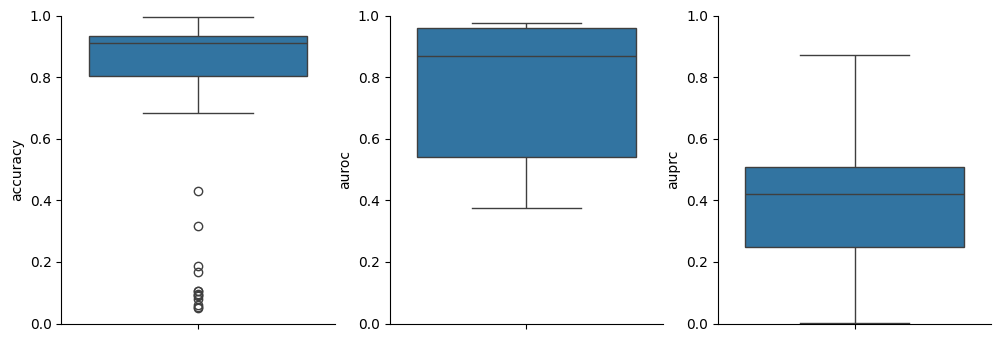

In [19]:
# Metrics

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

b = sns.boxplot(data=mhcbench_v2_result_df, y='accuracy', ax=axs[0])
b.set(ylim=(0,1))

b = sns.boxplot(data=mhcbench_v2_result_df, y='auroc', ax=axs[1])
b.set(ylim=(0,1))

b = sns.boxplot(data=mhcbench_v2_result_df, y='auprc', ax=axs[2])
b.set(ylim=(0,1))

sns.despine(top=True,right=True)


In [21]:
mhcbench_v2_result_df.median()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


peptide_count    18961.000000
accuracy             0.911604
f1                   0.046200
auroc                0.868767
auprc                0.421498
rule_count          27.500000
dtype: float64